Code adapted from https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/Subscriptions-API/LST_PV_Subscription_Example.ipynb


# Land Surface Temperature Workflow

## Imports

Credentials: The first step is to [Authenticate with Planet services](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#authenticate-with-planet-services). When running the following code you will be prompted to enter your [Planet API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key), which will be stored securely for making the subsequent calls to the Subscriptions API.

In [ ]:
# Needed packages
import base64
import datetime as dt
from getpass import getpass
from io import StringIO
import json

import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import rioxarray as rx
import xarray as xr

from planet import Auth
from planet import Session
from planet.clients.subscriptions import SubscriptionsClient
from planet.subscription_request import planetary_variable_source, build_request

import geemap

# -----------------------------------------------------------------------------------------
# Credentials

api_key = getpass('Enter your API key:')
auth = Auth.from_key(api_key)

In [2]:
# Define Area of Interest (AOI)
geometry = {
  "type":"Polygon",
  "coordinates":[
    [
      [-83.364112,8.754785],
      [-83.364112,8.841597],
      [-83.188301,8.841597],
      [-83.188301,8.754785],
      [-83.364112,8.754785]
    ]
  ]
}

# # Get the geometry from a geojson file
# fname="my_geometry.geojson"
# with open(fname, "r") as file:
#     geojson_data = json.load(file)
# geometry = geojson_data["features"][0]

### Desplay the AOI on the map (optional)

In [3]:
from ipyleaflet import GeoJSON
#Desplay AOI
m = geemap.Map(basemap = 'HYBRID',center=  [8.783665, -83.279252], zoom=12)

json_layer = GeoJSON(
    data=geometry,
    name="Test Area",
    style = {
    "fillColor": "#000000",      # fill color (irrelevant since fillOpacity = 0)
    "color": "red",          # border color
    "weight": 2,                 # border thickness
    "fillOpacity": 0             # fully transparent fill
},
    hover_style={"fillColor": "red", "fillOpacity": 0.5},
)

m.add(json_layer)

m

Map(center=[8.783665, -83.279252], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

## Planet Subscriptions API
Additioal resources:
https://docs.planet.com/develop/apis/subscriptions/
/n
https://github.com/planetlabs/training-workshop/blob/master/Subscription_API/Subscription_API.ipynb

### Check your existing subscriptions

First, we will check our orders list to make sure authentication and communication is working as expected.

We want to get a response code of 200 from this API call. To troubleshoot other response codes, see the List Orders AOI reference.

If you recieve a 401 make sure that you correclty entered your API key

In [4]:
import requests
from requests.auth import HTTPBasicAuth

subscriptions_url = "https://api.planet.com/subscriptions/v1"
auth = HTTPBasicAuth(api_key, '')
response = requests.get(subscriptions_url, auth=auth)
print("API Communication status: ", response, '\n') # if code 200 is desplayed than communication is succesful

for i in range(len(response.json()['subscriptions'])):
    print("Name: ", response.json()['subscriptions'][i]['name'])
    print("ID: ", response.json()['subscriptions'][i]['id'])
    print("Satus: ", response.json()['subscriptions'][i]['status'])
    print("End time: ", response.json()['subscriptions'][i]['source']['parameters']['end_time'])
    print('\n')
    

API Communication status:  <Response [200]> 

Name:  LST_100m_OSA_test1
ID:  c78f85d5-64ed-4298-9988-3acf496106aa
Satus:  cancelled
End time:  2025-01-01T00:00:00Z


Name:  LST_100m_OSA_test1
ID:  77457261-ca6d-448f-a111-0694cf7e428b
Satus:  running
End time:  2025-01-01T00:00:00Z


Name:  LST_test (SH subscription 562972e1-d345-42b5-b1ec-f3ad7822c7a2)
ID:  c0ca0561-d859-4456-b43b-bd15fff5ac31
Satus:  cancelled
End time:  2025-05-07T23:59:59.999Z




### Cancel subscription

In [ ]:
subscriptions_id = 'c78f85d5-64ed-4298-9988-3acf496106aa'
subscription_url = subscriptions_url + '/' + subscriptions_id

# report order state
#subscription_url = "https://api.planet.com/subscriptions/v1/SUB_ID"
print(subscription_url)
requests.get(subscription_url, auth=auth).json()['status']

# POST https://api.planet.com/subscriptions/v1/<subscription_id>/cancel
cancel_url = subscription_url + "/cancel"
response = requests.post(cancel_url, auth=auth)
print (response)

# report order state - it could take a little while to cancel
print("Status: ", requests.get(subscription_url, auth=auth).json()['status'])


https://api.planet.com/subscriptions/v1/c78f85d5-64ed-4298-9988-3acf496106aa
<Response [200]>
cancelled


### Create New Subscription

This first example creates a subscription for 5 years of 100m resolution LST data over a small area on the OSA Peninsula, Costa Rica.

Subscriptions can be created with or without a delivery parameter, which specifies a storage location to deliver raster data. For this first analysis we do not require raster assets, so the delivery parameter has been omitted to create a metadata-only subscription.

Using the [create_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.create_subscription) method, we POST the request defined above to `https://api.planet.com/subscriptions/v1`


In [ ]:
# Choose the name of your subscription
subscription_name = "LST_100m_OSA_test1"

# Define data source, aoi, date range
pv_source = planetary_variable_source(var_type="land_surface_temperature",
                                      var_id="LST-AMSR2_V1.0_100",
                                      geometry=geometry,
                                      start_time=dt.datetime(2020, 1, 1),
                                      end_time=dt.datetime(2025, 1, 1))

# Wraps all parameters into a request object to be sent to the Planet API.
request = build_request(subscription_name, source=pv_source, delivery={},)

# Create the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_desc = await cl.create_subscription(request)
print(f"{subscription_desc['id']} named {subscription_desc['name']} created")

### Image metadata
We can start retrieving the subscription data even if the status is 'running'. The `metadata-only` (timeseries) results generated for this subscription is retrieved directly in CSV format with `get_results_csv`. We can use the Pandas library to read this into a DataFrame to perform further analysis and to create a nice time series visualization.

In [4]:
# Copy paste the id of the subscription you will like to use as printed in the code cells from the previous section
subscription_id ='77457261-ca6d-448f-a111-0694cf7e428b'
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    results_desc = cl.get_results_csv(subscription_id=subscription_id)
    results_desc_list = [i async for i in results_desc]

df = pd.read_csv(StringIO("\n".join(results_desc_list)), parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time",)
display(df)

,id,item_datetime,status,created,updated,errors,item_id,lst.band-1.mean,lst.band-1.valid_percent,source_id
local_solar_time,,,,,,,,,,
2020-01-01 01:30:00,de80e47c-3722-4896-8e06-1d595efe600e,2020-01-01 07:30:00+00:00,SUCCESS,2025-05-10T22:57:21.571224Z,2025-05-10T22:57:21.571224Z,{},LST-AMSR2_V1.0_100_2020-01-01T0130,NaN,0,LST-AMSR2_V1.0_100
2020-01-01 13:30:00,ece28173-0e9f-4c03-9a27-50b9b4c35c99,2020-01-01 19:30:00+00:00,SUCCESS,2025-05-11T02:31:16.67428Z,2025-05-11T02:31:16.67428Z,{},LST-AMSR2_V1.0_100_2020-01-01T1330,302.52,99,LST-AMSR2_V1.0_100
2020-01-02 01:30:00,0ee414b3-340d-45e2-8a6a-cca76e20f59a,2020-01-02 07:30:00+00:00,SUCCESS,2025-05-11T06:24:21.562312Z,2025-05-11T06:24:21.562312Z,{},LST-AMSR2_V1.0_100_2020-01-02T0130,293.35,99,LST-AMSR2_V1.0_100
2020-01-02 13:30:00,0fc983c7-1f36-48f6-8b3e-48d51eb07205,2020-01-02 19:30:00+00:00,SUCCESS,2025-05-11T01:19:04.475981Z,2025-05-11T01:19:04.475981Z,{},LST-AMSR2_V1.0_100_2020-01-02T1330,301.08,99,LST-AMSR2_V1.0_100
2020-01-03 01:30:00,c380bdb8-8531-41fc-b394-b7839b69cbc9,2020-01-03 07:30:00+00:00,SUCCESS,2025-05-10T23:48:05.713664Z,2025-05-10T23:48:05.713664Z,{},LST-AMSR2_V1.0_100_2020-01-03T0130,294.93,99,LST-AMSR2_V1.0_100
...,...,...,...,...,...,...,...,...,...,...
2024-12-29 13:30:00,eb2e1367-d316-4a5c-b939-e30fd4b4e522,2024-12-29 19:30:00+00:00,SUCCESS,2025-05-11T00:38:54.049154Z,2025-05-11T00:38:54.049155Z,{},LST-AMSR2_V1.0_100_2024-12-29T1330,296.40,99,LST-AMSR2_V1.0_100
2024-12-30 01:30:00,5cb4285f-7d9e-4d69-82f4-e19dd7c015a1,2024-12-30 07:30:00+00:00,SUCCESS,2025-05-11T06:42:17.968267Z,2025-05-11T06:42:17.968267Z,{},LST-AMSR2_V1.0_100_2024-12-30T0130,290.76,99,LST-AMSR2_V1.0_100
2024-12-30 13:30:00,fdf61b0a-81a5-4f9c-a3b1-ed6f9a654963,2024-12-30 19:30:00+00:00,SUCCESS,2025-05-11T06:42:17.534543Z,2025-05-11T06:42:17.534543Z,{},LST-AMSR2_V1.0_100_2024-12-30T1330,300.83,99,LST-AMSR2_V1.0_100


### Plot time series from metadata

Now, we are ready to analyze the average temperature of the agricultural region over time. Two time series plots are created: one for nighttime observations (captured at 01:30 solar time) and one for daytime observations (captured at 13:30 solar time). A rolling backward windows average is also plotted to show the 10 days trend. When the subscription is completed, this will be a full record of the temperature data over the four years requested.

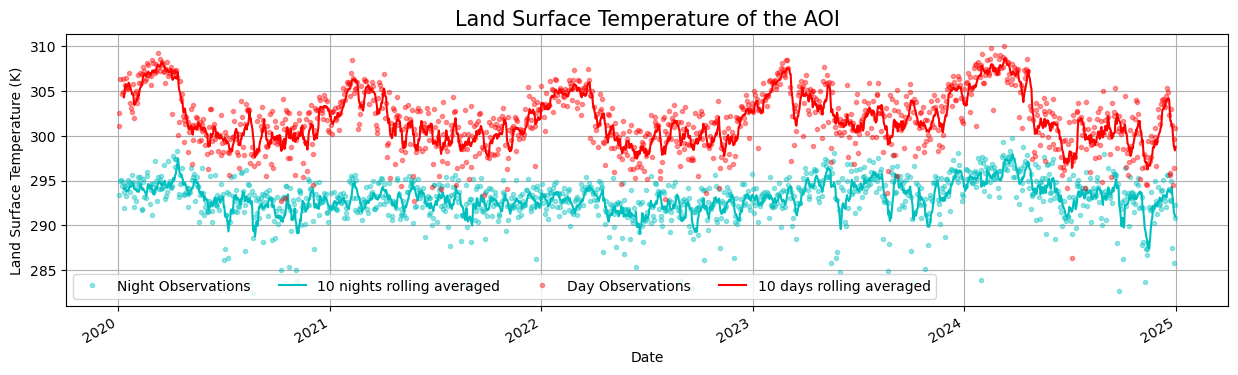

In [7]:
backward_average_window_size=10

# Plot the Land Surface Temperature time-series for nighttime observations
df.between_time("1:15", "1:45")["lst.band-1.mean"].plot(
    grid=True, style="c.", alpha=0.4, label="Night Observations", figsize=(15, 4)
)
df["average"] = df.between_time("1:15", "1:45")["lst.band-1.mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:].plot(
    grid=True, style="c-", label=f"{backward_average_window_size} nights rolling averaged", figsize=(15, 4)
)

# Plot the Land Surface Temperature time-series for daytime observations
df.between_time("13:15", "13:45")["lst.band-1.mean"].plot(
    grid=True, style="r.", alpha=0.4, label="Day Observations", figsize=(15, 4)
)
df["average"] = df.between_time("13:15", "13:45")["lst.band-1.mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:].plot(
    grid=True, style="r-", label=f"{backward_average_window_size} days rolling averaged", figsize=(15, 4)
)

# Extra information for the visualization
plt.ylabel("Land Surface Temperature (K)", size = 10)
plt.xlabel("Date", size = 10)
plt.title("Land Surface Temperature of the AOI", size = 15)
plt.legend(ncols=4)

## Data API (TO DO)
Not available for Planet Products
https://docs.planet.com/develop/apis/data/reference/


## Tile Services API (TO DO)
https://docs.planet.com/develop/apis/tiles/

In [86]:
# import requests
# from requests.auth import HTTPBasicAuth

# BASE_URL = "https://tiles1.planet.com/data/v1/{item_type}/{item_id}/{z}/{x}/{y}.png"
# res = requests.get(url=BASE_URL, auth=auth)

# print(res.status_code)
# # make a request to Tile Services API and test the response

# item_type="land_surface_temperature"
# item_id="LST-AMSR2_V1.0_100_2023-03-18T0130	"

# --------------------------------------------------------
# tile_url = 'https://tiles0.planet.com/data/v1/layers'
# #Copy the list of scene IDs from the API dialog into the ids JSON
# data = {
#   "ids": [
#     "LST-AMSR2_V1.0_100_2023-03-18T0130, LST-AMSR2_V1.0_100_2023-03-18T1330"
#     ]
# }

# res = requests.post(tile_url, auth=(api_key, ""), data=data)
# print(res)
# # name = res.json()["name"]
# name = "LST-AMSR2_V1.0_100_2023-03-18T0130"
# url = "{}/wmts/{}?api_key={}".format(tile_url,name, api_key)
# ---------------------------------------------------------

url = "https://tiles1.planet.com/data/v1/land_surface_temperature/LST-AMSR2_V1.0_100_2023-03-18T0130/14/12915/8124.png?api_key={PLAKc52bff062d1b4fe9bd6664e0c640a78d}"
print(url)

https://tiles1.planet.com/data/v1/land_surface_temperature/LST-AMSR2_V1.0_100_2023-03-18T0130/14/12915/8124.png?api_key={PLAKc52bff062d1b4fe9bd6664e0c640a78d}


## Subscription with Raster delivery (to google cloud stoorage)
In addition to providing metadata over an Area of Interest, you can also configure the delivery of raster results directly to a cloud storage location. We will use the same method as above to generate the request but now provide an additional `delivery` configuration. In this example, we will now focus on the month of July 2022.

See the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or the [API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) to review the configuration options for different cloud storage providers. This example uses Google Cloud Storage.

To deliver results directly to a Google Cloud Storage bucket, specify the delivery location and provide your authentication credentials. These credentials will require read/write permissions on the specified bucket. See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key with the appropriate permissions. When using AWS, Azure or OCS, use the corresponding credentials for those platforms.

In [11]:
# Only for Cloud Storage Delivery
bucket_name="<YOUR BUCKET NAME>"
GOOGLE_APPLICATION_CREDENTIALS="~/.config/gcloud/application_default_credentials.json" # Adjust to your json file location for a GCP service account key with Cloud Storage permission

# Credentials are expected in base64 format -the following reads the json key as bytes,
# applies the base64 encoding and decodes back to a python str
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

# Your GCP bucket and credentials to save rasters
delivery_config_gcp = {
    "type": "google_cloud_storage",
    "parameters": {
        "bucket": bucket_name,
        "credentials": gcs_credentials_base64,
    }
}

FileNotFoundError: [Errno 2] No such file or directory: '~/.config/gcloud/application_default_credentials.json'

In [46]:
subscription_name = "LST_100m Imperial Nebraska July 2022"

pv_source = planetary_variable_source(var_type="land_surface_temperature",
                                      var_id="LST-AMSR2_V1.0_100",
                                      geometry=geometry,
                                      start_time=dt.datetime(2022, 7, 1),
                                      end_time=dt.datetime(2022, 8, 1))

request = build_request(subscription_name, source=pv_source, delivery=delivery_config_gcp,)

In [54]:
# Create the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_details = await cl.create_subscription(request)
print(f"{subscription_details['id']} named {subscription_details['name']} created")

942d85b3-4ab2-4774-afa8-cadc804c39f0 named LST_100m Imperial Nebraska July 2022 created


### Visualize data from subscription delivery
The geotiff (raster) files will now be delivered to our Cloud Storage bucket.

The rioxarray extension to [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) can be used to open and map the delivered GeoTIFF files directly from their cloud storage location.

Rasterio uses GDAL under the hood, which supports accessing [network based file systems](https://gdal.org/user/virtual_file_systems.html#network-based-file-systems) across different cloud providers. For more information, see:

- [Amazon Web Service](https://gdal.org/user/virtual_file_systems.html#vsis3-aws-s3-files)
- [Google Cloud](https://gdal.org/user/virtual_file_systems.html#vsigs-google-cloud-storage-files)
- [Microsoft Azure](https://gdal.org/user/virtual_file_systems.html#vsiaz-streaming-microsoft-azure-blob-files-streaming)

In the following example, the data is read directly from our previously configured Google Cloud Storage bucket to visualize the Land Surface Temperature 100m resolution map over our AOIs on the 18th of July, 2022.

<xarray.Dataset>
Dimensions:      (x: 369, y: 206)
Coordinates:
  * x            (x) float64 -101.4 -101.4 -101.4 ... -101.1 -101.1 -101.1
  * y            (y) float64 40.71 40.71 40.71 40.71 ... 40.53 40.53 40.53 40.53
    spatial_ref  int64 0
Data variables:
    band_1       (y, x) float32 ...
    band_2       (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area


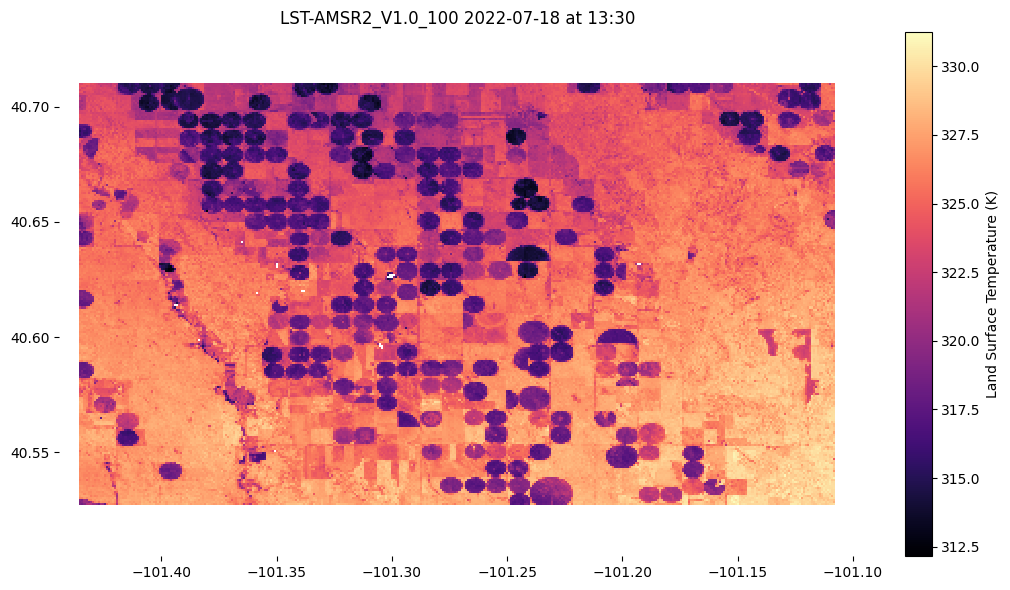

In [69]:
# Set the filepath to the 18 July 2022 GeoTIFF asset
date="2022-07-18"

subscription_id = subscription_details["id"]
lst_file_location = f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/LST-AMSR2_V1.0_100-{date.replace('-','')}T1330_lst.tiff"

# Use the Google Application credentials to allow access to the storage location
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
    lst_data = rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True)
    print(lst_data)

    lst_data = lst_data.rename_vars({
        "band_1":"Land Surface Temperature (K)",
        "band_2":"Masked LST values (K)",
    })

    aspect = lst_data["x"].size / lst_data["y"].size

    fig, ax = plt.subplots(figsize=(6*aspect, 6))
    lst_data["Land Surface Temperature (K)"].plot(ax=ax, cmap="magma", )

    ax.set_title(f"LST-AMSR2_V1.0_100 {date} at 13:30")
    ax.axis("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_frame_on(False)
    plt.tight_layout()

In the second spatial analysis, we open all the geotiffs between two dates into a xarray.DataSet and we compute the monthly average of temperature.

In [70]:
date_range = pd.date_range(start="2022-07-01", end="2022-07-31").strftime("%Y-%m-%d")
subscription_id = subscription_details["id"]

july_data = []
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
  for date in date_range:
    lst_file_location = f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/LST-AMSR2_V1.0_100-{date.replace('-','')}T1330_lst.tiff"
    july_data.append(rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True).assign_coords({"date": date}))

timeseries = xr.concat(july_data, dim="date")
timeseries['date'] = pd.DatetimeIndex(timeseries['date'].values)
timeseries = timeseries.rename_vars({
    "band_1":"Land Surface Temperature (K)",
    "band_2": "Masked LST values (K)",
})

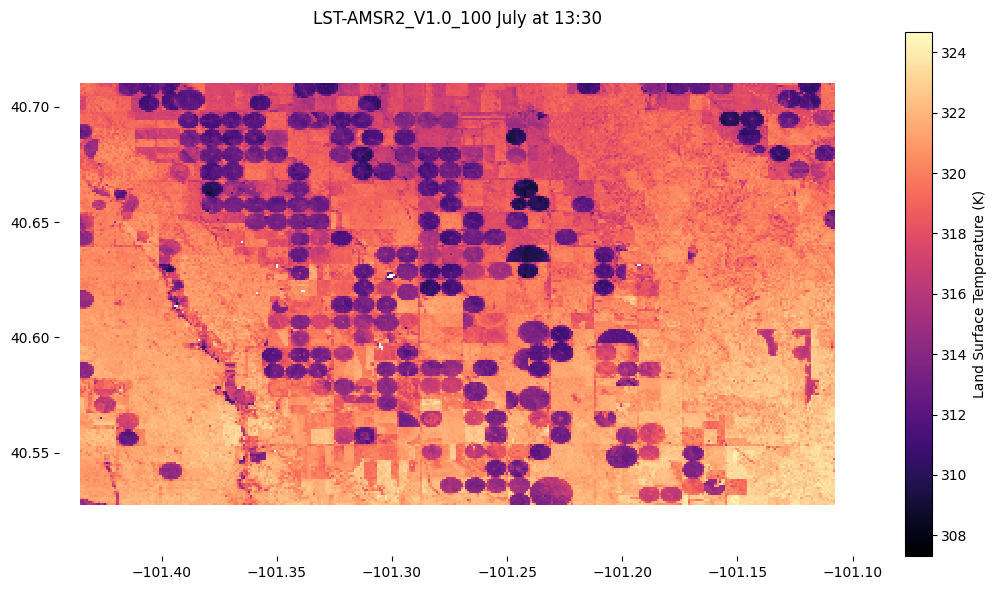

In [56]:
average = timeseries.resample(date="M").mean()

aspect = average["x"].size / average["y"].size

fig, ax = plt.subplots(figsize=(6*aspect, 6))
average["Land Surface Temperature (K)"].plot(ax=ax, cmap="magma", )

ax.set_title("LST-AMSR2_V1.0_100 July at 13:30")
ax.axis('equal')
ax.set_frame_on(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

Finally, we save the LST averaged map as a new locally stored geotiff.

In [55]:
average["Land Surface Temperature (K)"].rio.to_raster("LST-AMSR2_V1.0_100_July_1330.tiff")